In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import scipy.stats
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.neighbors
import sklearn.ensemble
import sklearn.feature_selection
import unittest

import sklearn.datasets
import sklearn.tree

import optuna

***Import dataset/ML code from other notebook***

In [75]:
cd /Users/loganroberts/Learn2Therm/ValidProt/data

/Users/loganroberts/Learn2Therm/ValidProt/data


In [76]:
#convert to pandas df
df_original = pd.read_csv('learn2therm_sample_50k/learn2therm_sample_50k.csv')

In [77]:
df_original.head()

,Unnamed: 0,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,thermo_index,...,bit_score_16s,m_ogt,t_ogt,ogt_difference,m_protein_seq,t_protein_seq,m_protein_desc,t_protein_desc,m_protein_len,t_protein_len
0,0,0.287582,0.217822,0.215686,160,0.792079,152,0.737864,131,875,...,1153.0,27.5,50.0,22.5,MAESGTSRRADHLVPVPGPDAEPPAVADELLRAVGRGDEQAFGRLY...,MPSQITESERIELAERFERDALPLLDQLYSAALRMTRNPADAEDLV...,ECF RNA polymerase sigma factor SigK,sigma-70 family RNA polymerase sigma factor,206,202
1,1,0.319635,0.295359,0.297872,218,0.919831,226,0.969957,282,11324,...,1014.0,25.0,54.0,29.0,MARIALVDDDRNILTSVSMTLEAEGFEVETYNDGQSALDAFNKRMP...,MRVLLVEDDPNTSRSIEMMLTHANLNVYATDMGEEGIDLAKLYDYD...,response regulator transcription factor,response regulator transcription factor,233,237
2,2,0.279621,0.234127,0.218924,211,0.837302,210,0.731707,96,875,...,1138.0,28.0,50.0,22.0,MKDTVVFVTGAARGIGAHTARLAVARGARVALVGLEPHLLADLAAE...,MTPEQIFSGQTAIVTGGASGIGAATVEHIARRGGRVFSVDLSYDSP...,SDR family oxidoreductase,SDR family oxidoreductase,287,252
3,3,0.327273,0.200743,0.214712,166,0.617100,163,0.696581,175,875,...,1077.0,28.0,50.0,22.0,MTSGLWERVLDGVWVTIQLLVLSALLATAVSFVVGIARTHRLWIVR...,MAMSRRKRGQLARGIQYAILVIVVVVLALLADWGKIGKAFFDWEAA...,ectoine/hydroxyectoine ABC transporter permeas...,amino acid ABC transporter permease,234,269
4,4,0.338710,0.318182,0.287671,60,0.909091,71,0.887500,61,9827,...,991.0,30.0,50.0,20.0,MIISLRRGLRFIRFIVFFAALVYLFYHVLDLFNGWISPVDQYQMPT...,MKRMVWRTLKVFIIFIACTLLFYFGLRFMHLEYEQFHRYEPPEGPA...,YqzK family protein,YqzK family protein,80,66


The following cells are attempts at creating a classification column. Having trouble with the code. Gonna create a dummy.

Update: turn categories into a dictionary and iterate through

ESM - can return a continuous represenation of an AA sequence. Look up repo for ESM

start by testing on a single sequence 

In [78]:
#isolate the categories that appear more than 500 times

categories = df_original['t_protein_desc'].value_counts()
categories = categories.iloc[categories.values > 500]
categories_dict = {item: None for item in categories.index}

list_of_cats = list(categories_dict.keys())
list_of_cats

['ABC transporter ATP-binding protein',
 'SDR family oxidoreductase',
 'ATP-binding cassette domain-containing protein',
 'response regulator transcription factor',
 'ABC transporter permease',
 'TetR/AcrR family transcriptional regulator',
 'carbohydrate ABC transporter permease',
 'sugar ABC transporter permease',
 'hypothetical protein',
 'SDR family NAD(P)-dependent oxidoreductase',
 'response regulator']

In [79]:
df = df_original[df_original.t_protein_desc.isin(list_of_cats)]
df.shape

(23783, 30)

In [80]:
df['protein_match'] = df['t_protein_desc'] == df['m_protein_desc']
df['protein_match'].head()

<ipython-input-80-effa623dacb1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['protein_match'] = df['t_protein_desc'] == df['m_protein_desc']


1      True
2      True
5      True
9     False
12    False
Name: protein_match, dtype: bool

In [81]:
df['protein_match'].value_counts()

True     13099
False    10684
Name: protein_match, dtype: int64

In [82]:
#get rid of stuff that isn't quantitative

df = df.drop(columns = ['Unnamed: 0','thermo_index', 'm_protein_seq', 't_protein_seq',
                        'm_protein_desc', 't_protein_desc'])

In [83]:
df.head()

,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,meso_index,prot_pair_index,...,scaled_local_symmetric_percent_id_16s,query_align_cov_16s,subject_align_cov_16s,bit_score_16s,m_ogt,t_ogt,ogt_difference,m_protein_len,t_protein_len,protein_match
1,0.319635,0.295359,0.297872,218,0.919831,226,0.969957,282,13026,92992745,...,0.902522,1.000000,1.000000,1014.0,25.0,54.0,29.0,233,237,True
2,0.279621,0.234127,0.218924,211,0.837302,210,0.731707,96,8203,157628663,...,0.923531,1.000000,1.000000,1138.0,28.0,50.0,22.0,287,252,True
5,0.333333,0.267380,0.254453,148,0.791444,163,0.791262,127,3582,20752996,...,0.880157,0.997391,0.997370,942.0,17.5,42.0,24.5,206,187,True
9,0.333333,0.295082,0.291498,218,0.893443,221,0.884000,158,742,85102366,...,0.910105,0.998040,0.998022,1085.0,26.0,50.0,24.0,250,244,False
12,0.354067,0.245847,0.225954,208,0.691030,216,0.610170,264,13575,55279368,...,0.912500,0.996721,0.996700,1095.0,28.0,52.5,24.5,354,301,False


from pairplot below, it looks like query_align_cov_16s and subject_align_cov_16s dont correlate with anything

In [84]:
# sns.pairplot(df.sample(500),height = 4)

#i dont see much higher-order correlation, so it's likely we can use linear regression

In [85]:
df = df.drop(columns = ['query_align_cov_16s', 'subject_align_cov_16s'])

In [86]:
df.describe()

,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,meso_index,prot_pair_index,...,taxa_pair_index,local_gap_compressed_percent_id_16s,scaled_local_query_percent_id_16s,scaled_local_symmetric_percent_id_16s,bit_score_16s,m_ogt,t_ogt,ogt_difference,m_protein_len,t_protein_len
count,23783.000000,23783.000000,23783.000000,23783.000000,23783.000000,23783.000000,23783.000000,23783.000000,23783.000000,2.378300e+04,...,23783.000000,23783.000000,23783.000000,23783.000000,23783.000000,23783.000000,23783.000000,23783.000000,23783.000000,23783.000000
mean,0.330515,0.255968,0.251793,206.720725,0.781491,206.319304,0.770447,209.895766,8057.971745,9.088823e+07,...,363429.641887,0.906876,0.903185,0.905010,1061.304503,27.371715,51.477799,24.106084,271.792961,267.108397
std,0.060568,0.075837,0.075889,45.130804,0.135684,45.314127,0.162151,115.963286,4602.593029,5.206080e+07,...,226799.643391,0.015064,0.015445,0.015098,74.656304,3.617415,3.577307,3.509046,48.848302,52.720419
min,0.179012,0.100817,0.059908,25.000000,0.481482,25.000000,0.082019,36.000000,5.000000,1.219000e+03,...,4885.000000,0.876590,0.836055,0.880026,891.000000,7.000000,41.000000,20.000000,52.000000,33.000000
25%,0.293333,0.205432,0.205288,188.000000,0.675035,188.000000,0.664506,135.000000,4081.000000,4.647432e+07,...,174094.000000,0.896178,0.893115,0.893770,1011.000000,27.500000,50.000000,22.000000,240.000000,237.000000
50%,0.321429,0.243590,0.239845,211.000000,0.786325,211.000000,0.791506,193.000000,7997.000000,9.155334e+07,...,312334.000000,0.906122,0.902487,0.903840,1057.000000,28.000000,52.500000,24.500000,263.000000,261.000000
75%,0.354665,0.290566,0.283247,232.000000,0.902174,230.000000,0.905455,253.000000,12100.000000,1.353189e+08,...,617843.000000,0.916392,0.912787,0.914921,1108.000000,29.000000,52.500000,24.500000,305.000000,305.000000
max,0.923077,0.914798,0.916854,388.000000,1.000000,388.000000,1.000000,1359.000000,16345.000000,1.814861e+08,...,744518.000000,0.999351,0.993544,0.996439,1618.000000,40.000000,78.000000,56.000000,400.000000,400.000000


In [87]:
df.head()

,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,meso_index,prot_pair_index,...,local_gap_compressed_percent_id_16s,scaled_local_query_percent_id_16s,scaled_local_symmetric_percent_id_16s,bit_score_16s,m_ogt,t_ogt,ogt_difference,m_protein_len,t_protein_len,protein_match
1,0.319635,0.295359,0.297872,218,0.919831,226,0.969957,282,13026,92992745,...,0.901907,0.900068,0.902522,1014.0,25.0,54.0,29.0,233,237,True
2,0.279621,0.234127,0.218924,211,0.837302,210,0.731707,96,8203,157628663,...,0.920812,0.919007,0.923531,1138.0,28.0,50.0,22.0,287,252,True
5,0.333333,0.267380,0.254453,148,0.791444,163,0.791262,127,3582,20752996,...,0.883049,0.876712,0.880157,942.0,17.5,42.0,24.5,206,187,True
9,0.333333,0.295082,0.291498,218,0.893443,221,0.884000,158,742,85102366,...,0.909508,0.905944,0.910105,1085.0,26.0,50.0,24.0,250,244,False
12,0.354067,0.245847,0.225954,208,0.691030,216,0.610170,264,13575,55279368,...,0.913702,0.909508,0.912500,1095.0,28.0,52.5,24.5,354,301,False


<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


Text(0, 0.5, 'Count')

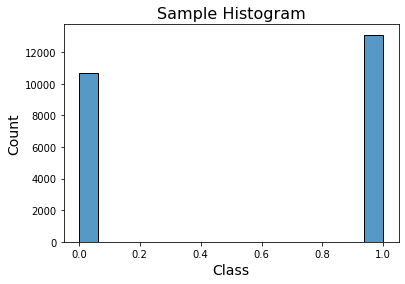

In [88]:
#plot empirical distribution of scaled_local_query_percent_id

target = df['protein_match']
#create histplot
fig, ax = plt.subplots()

sns.histplot(data = df, x = target)

ax.set_title('Sample Histogram', fontsize=16)
ax.set_xlabel('Class', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

In [89]:
# print('The mean is: {} and the standard deviation is: {}.'.format(target.mean(),target.std())) 

# print('The minimum bit score is: {} and the maximum bit score is: {}.'.format(target.min(),target.max()))

1) Split dev and test data:

In [90]:
df = df.drop(columns = ['meso_index', 'meso_protein_int_index', 'local_gap_compressed_percent_id_16s', 
                        'scaled_local_query_percent_id_16s', 'scaled_local_symmetric_percent_id_16s',
                       'bit_score_16s', 'm_ogt', 't_ogt', 'taxa_pair_index', 'thermo_protein_int_index'
                       , 'prot_pair_index', 'ogt_difference'])

In [91]:
#choosing 80/20 split instead of 85/15 because of volume of data

dev, test = sklearn.model_selection.train_test_split(df, test_size=0.15, random_state=1)

#might want to name the above split train/val, since we don't really have "test data" yet
train, val = sklearn.model_selection.train_test_split(dev, test_size=0.15, random_state=1)

print(dev.shape)
print(test.shape)
print(train.shape)
print(val.shape)

(20215, 11)
(3568, 11)
(17182, 11)
(3033, 11)


In [92]:
target = 'protein_match'
input_features = [columns for columns in df]
input_features.remove(target)

In [93]:
print(input_features)
print(target)

['local_gap_compressed_percent_id', 'scaled_local_query_percent_id', 'scaled_local_symmetric_percent_id', 'query_align_len', 'query_align_cov', 'subject_align_len', 'subject_align_cov', 'bit_score', 'm_protein_len', 't_protein_len']
protein_match


In [94]:
# predicting values 

dev_X = dev[input_features].values
test_X = test[input_features].values

dev_y = dev[target].values.reshape(-1,1)
test_y = test[target].values.reshape(-1,1)  

print(dev_X.shape, test_X.shape, dev_y.shape, test_y.shape)

(20215, 10) (3568, 10) (20215, 1) (3568, 1)


In [95]:
train_X = train[input_features].values
val_X = val[input_features].values

train_y = train[target].values.reshape(-1,1)
val_y = val[target].values.reshape(-1,1) 

2) Scale the data

In [96]:
scaler = sklearn.preprocessing.StandardScaler()
dev_X = scaler.fit_transform(dev_X)
test_X = scaler.fit_transform(test_X)
train_X = scaler.fit_transform(train_X)
val_X = scaler.fit_transform(val_X)

3) Regularize the data -L1 or L2? Read online

4. Train the model

In [97]:
#Random Forest

model = sklearn.ensemble.RandomForestClassifier()
model.fit(dev_X, dev_y.ravel())

RandomForestClassifier()

5. Test the model, report relevant statistics

In [98]:
score = model.score(test_X, test_y)
print('Model score is: {}'.format(score))

preds = model.predict(test_X)
print(preds)

Model score is: 0.6488228699551569
[ True  True  True ...  True False  True]


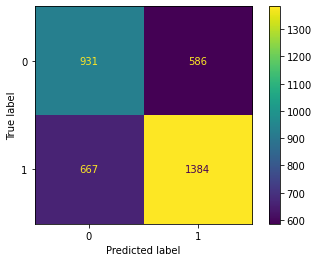

In [99]:
#confusion matrix

confusion_matrix = sklearn.metrics.confusion_matrix(preds, test_y)
sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix).plot()

**Start with Random Forest Classifier**

Random Search

In [100]:
# create hyperparameter value options for each hyperparameter
max_depth_options = [1,2,3,4,5]
min_weight_fraction_options = [0, 0.1, 0.2, 0.3, 0.4]

In [103]:
# Define the grid of hyperparameter options

param_grid = {
    'max_depth': max_depth_options,
    'min_weight_fraction_leaf': min_weight_fraction_options,
    'n_estimators': [50,100,150,200]
}
# Create the grid search object
# Give it the model we want to use, the hyperparameters to search over
#CV param does cross validation for me
random_search = sklearn.model_selection.RandomizedSearchCV(
    sklearn.ensemble.RandomForestClassifier(),
    param_grid,
    cv=5
)
# execute the grid search
random_search.fit(dev_X, dev_y.ravel())

print('Best hyperparameters: ', random_search.best_params_)

Best hyperparameters:  {'n_estimators': 100, 'min_weight_fraction_leaf': 0, 'max_depth': 5}


In [105]:
model = sklearn.ensemble.RandomForestClassifier(n_estimators=100, min_weight_fraction_leaf=0.0002153178126766452, max_depth=5)
model.fit(dev_X, dev_y.ravel())
print(model.score(test_X, test_y))

0.6221973094170403


TPE with Optuna

In [60]:
def train_evaluate_hyperparameters(max_depth, min_weight_fraction_leaf, n_estimators):
    
    # create RF classifier model
    model = sklearn.ensemble.RandomForestClassifier(max_depth=max_depth, min_weight_fraction_leaf=min_weight_fraction_leaf,
                                               n_estimators=n_estimators)
    
    # train the model on the training set
    fit = model.fit(train_X, train_y)
    
    # evaluate the model on the validation set
    score = model.score(val_X, val_y)
    
    return score

In [69]:
def id_best_hyperparams(trial):
    # define hyperparameter space
    max_depth_options = trial.suggest_int('max_depth_options', 1, 5)
    min_weight_fraction_options = trial.suggest_uniform("min_weight_fraction_options", 0,0.4)
    n_estimator_options = trial.suggest_int('n_estimators', 50, 200, 50)
    
    # get the score for the hyperparameters chosen
    score = train_evaluate_hyperparameters(max_depth=max_depth_options, min_weight_fraction_leaf=min_weight_fraction_options,
                                          n_estimators=n_estimator_options)
    
    return score

study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
study.optimize(id_best_hyperparams, n_trials=50)
print('Best params: ', study.best_params)

[I 2023-03-07 15:30:04,808] A new study created in memory with name: no-name-bb186c39-4e99-42ea-a304-85f03176f334
<ipython-input-69-4902f5686a9d>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  min_weight_fraction_options = trial.suggest_uniform("min_weight_fraction_options", 0,0.4)
<ipython-input-60-658ba96c454f>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fit = model.fit(train_X, train_y)
[I 2023-03-07 15:30:05,408] Trial 0 finished with value: 0.5634685130234092 and parameters: {'max_depth_options': 1, 'min_weight_fraction_options': 0.3351248773184103, 'n_estimators': 100}. Best is trial 0 with value: 0.5634685130234092.
<ipython-input-69-4902f5686a9d>:4: FutureWarning: suggest_uniform has been depre

<ipython-input-69-4902f5686a9d>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  min_weight_fraction_options = trial.suggest_uniform("min_weight_fraction_options", 0,0.4)
<ipython-input-60-658ba96c454f>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fit = model.fit(train_X, train_y)
[I 2023-03-07 15:30:14,888] Trial 10 finished with value: 0.6106165512693703 and parameters: {'max_depth_options': 5, 'min_weight_fraction_options': 0.00854950130413712, 'n_estimators': 100}. Best is trial 10 with value: 0.6106165512693703.
<ipython-input-69-4902f5686a9d>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0

<ipython-input-69-4902f5686a9d>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  min_weight_fraction_options = trial.suggest_uniform("min_weight_fraction_options", 0,0.4)
<ipython-input-60-658ba96c454f>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fit = model.fit(train_X, train_y)
[I 2023-03-07 15:30:25,962] Trial 20 finished with value: 0.5809429607649192 and parameters: {'max_depth_options': 2, 'min_weight_fraction_options': 0.06900365014765031, 'n_estimators': 50}. Best is trial 13 with value: 0.6122650840751731.
<ipython-input-69-4902f5686a9d>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.

<ipython-input-69-4902f5686a9d>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  min_weight_fraction_options = trial.suggest_uniform("min_weight_fraction_options", 0,0.4)
<ipython-input-60-658ba96c454f>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fit = model.fit(train_X, train_y)
[I 2023-03-07 15:30:38,469] Trial 30 finished with value: 0.5624793933399275 and parameters: {'max_depth_options': 2, 'min_weight_fraction_options': 0.37729941902611436, 'n_estimators': 50}. Best is trial 21 with value: 0.6205077481041873.
<ipython-input-69-4902f5686a9d>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.

<ipython-input-69-4902f5686a9d>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  min_weight_fraction_options = trial.suggest_uniform("min_weight_fraction_options", 0,0.4)
<ipython-input-60-658ba96c454f>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fit = model.fit(train_X, train_y)
[I 2023-03-07 15:30:50,614] Trial 40 finished with value: 0.6119353775140125 and parameters: {'max_depth_options': 4, 'min_weight_fraction_options': 4.6904461048263325e-05, 'n_estimators': 100}. Best is trial 21 with value: 0.6205077481041873.
<ipython-input-69-4902f5686a9d>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v

Best params:  {'max_depth_options': 5, 'min_weight_fraction_options': 0.0002153178126766452, 'n_estimators': 100}


Let's define a function that can optimize hyperparameters for any model architecture we might be interested in.